In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
data_path = r'./Mask_Data' 
categorie = os.listdir(data_path)
 
labels = [i for i in range(len(categorie))] 

label_dict = dict(zip(categorie,labels)) 

print(label_dict) 

{'without_mask': 0, 'with_mask': 1}


In [3]:
data_train, data_test = [], []
target_train, target_test = [], []
list_img, target =[], []
img_size = 224
# importer le nom des images des données de train
for i in os.listdir('Mask_Data'):
     for j in os.listdir(f'Mask_Data/{str(i)}'):
            img = cv2.imread(f'Mask_Data/{str(i)}/{j}')
            img = cv2.resize(img,(224,224), interpolation = cv2.INTER_AREA) 
            list_img.append(img)
#             target.append(1 if i=='with_mask' else 0)
            target.append(label_dict[i])
print(os.listdir('Mask_Data')[0], target[0])
print(list_img[1].shape)

 

without_mask 0
(224, 224, 3)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X=np.array(list_img) 
y=np.array(target)
# Séparer les données en jeu de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
#(training_images, training_labels), (test_images, test_labels) = Mask_Data.load_data()

In [7]:
from keras.applications.vgg16 import VGG16
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=True) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

2022-03-31 19:24:06.199753: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-31 19:24:06.199998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 19:24:06.201178: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
num_classes = 2

model = tf.keras.models.Sequential([
    base_model, # Ajout du modèle VGG16
    Flatten(), 
    Dense(4096,activation='relu'),
    Dense(4096, activation='relu'),
    Dense(num_classes, activation='softmax')   
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              4100096   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8194      
Total params: 159,247,146
Trainable params: 20,889,602
Non-trainable params: 138,357,544
_________________________________________________________________


In [9]:
# Compile le modèle
model.compile(
    loss="sparse_categorical_crossentropy",    #quand il y a plus d'un label(classes)
    optimizer="Adam",                #descente de gradient
    metrics=["accuracy"])      #performance

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test), callbacks=[checkpoint,early])

Epoch 1/5


2022-03-31 19:24:08.006777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-31 19:24:08.026773: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2611200000 Hz


36/36 [==============================] - 181s 5s/step - loss: 0.3186 - accuracy: 0.8415 - val_loss: 0.1676 - val_accuracy: 0.9416
Epoch 2/5
36/36 [==============================] - 186s 5s/step - loss: 0.0769 - accuracy: 0.9778 - val_loss: 0.1434 - val_accuracy: 0.9549
Epoch 3/5
36/36 [==============================] - 185s 5s/step - loss: 0.0645 - accuracy: 0.9818 - val_loss: 0.1696 - val_accuracy: 0.9496
Epoch 4/5
36/36 [==============================] - 188s 5s/step - loss: 0.0441 - accuracy: 0.9868 - val_loss: 0.1403 - val_accuracy: 0.9549
Epoch 5/5
36/36 [==============================] - 191s 5s/step - loss: 0.0382 - accuracy: 0.9875 - val_loss: 0.1458 - val_accuracy: 0.9655


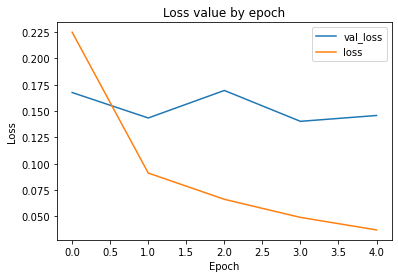

In [11]:
plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.title("Loss value by epoch")

plt.show()

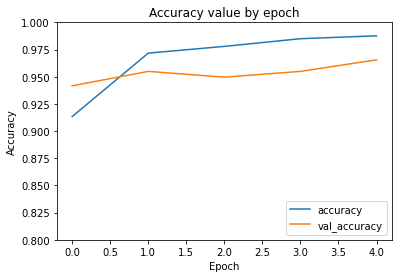

12/12 - 46s - loss: 0.1458 - accuracy: 0.9655


In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.80, 1])
plt.legend(loc='lower right')
plt.title("Accuracy value by epoch")

plt.show()

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)